In [1]:
import pickle
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
## https://www.cs.toronto.edu/~kriz/cifar.html

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)

You are using device: cuda


In [2]:
cifar10 = torch.empty(5, 10000,3,32,32)
cifar_y = torch.empty(5, 10000)
for i in range(5):
    batch = unpickle("C:\\Users\\galli\\Documents\\GitHub\\cs7643_final_project\\ensemble_ad\\cifar10-data\\cifar-10-batches-py\\data_batch_"+str(i+1))
    image_data = batch[b'data'].reshape(10000,3,32,32)
    cifar10[i] = torch.from_numpy(image_data)
    cifar_y[i] = torch.tensor(batch[b'labels'])
    
meta_file = 'C:\\Users\\galli\\Documents\\GitHub\\cs7643_final_project\\ensemble_ad\\cifar10-data\\cifar-10-batches-py\\batches.meta'
meta_data = unpickle(meta_file)

In [3]:
meta_data

{b'num_cases_per_batch': 10000,
 b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_vis': 3072}

In [109]:
cifar10[0,0].permute(1,2,0).size()

torch.Size([32, 32, 3])

Text(0.5, 1.0, "b'frog'")

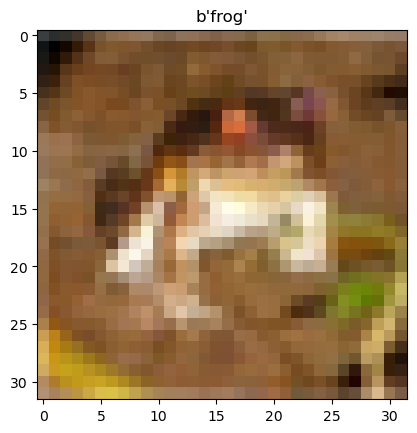

In [5]:
cifar10[0,0]
plt.imshow(cifar10[0,0].permute(1,2,0)/255)
plt.title(meta_data[b'label_names'][int(cifar_y[0,0])])

In [92]:
class Generator(nn.Module):
    def __init__(self, batch_size, z_dim, channel_dim, feature_dim):
        """
        Convolutional Generator
        """
        super(Generator, self).__init__()
        # Parameters
        self.batch_size = batch_size
        self.z_dim = z_dim
        self.feature_dim = feature_dim
        
        # Modules
        self.layer_0 = nn.Sequential(nn.Linear(z_dim, 6*6*feature_dim),
                                     nn.BatchNorm1d(6*6*feature_dim),
                                     nn.LeakyReLU())
        
        self.layer_1 = nn.Sequential(nn.ConvTranspose2d(in_channels = feature_dim, 
                                          out_channels = int(feature_dim/2),
                                          kernel_size = 5, stride=1, 
                                          padding=1, bias=False),
                                    nn.BatchNorm2d(int(feature_dim / 2)),
                                    nn.LeakyReLU())
        
        self.layer_2 = nn.Sequential(nn.ConvTranspose2d(in_channels = int(feature_dim/2), 
                                          out_channels = int(feature_dim/2**2),
                                          kernel_size = 3, stride=2, 
                                          padding=1, bias=False),
                                    nn.BatchNorm2d(int(feature_dim / 2**2)),
                                    nn.LeakyReLU())
        
        self.layer_3 = nn.Sequential(nn.ConvTranspose2d(in_channels = int(feature_dim/2**2), 
                                          out_channels = int(feature_dim/2**3),
                                          kernel_size = 3, stride=2, 
                                          padding=1, bias=False),
                                    nn.BatchNorm2d(int(feature_dim / 2**3)),
                                    nn.LeakyReLU())
        
        self.layer_4 = nn.Sequential(nn.ConvTranspose2d(in_channels = int(feature_dim/2**3), 
                                          out_channels = channel_dim,
                                          kernel_size = 6, stride=1, 
                                          padding=1, bias=False))
        
        self.tanh = nn.Tanh()
        
    def forward(self, input):
        l0 = self.layer_0(input)
        l0 = l0.view(self.batch_size, self.feature_dim, 6, 6)
        l1 = self.layer_1(l0)
        l2 = self.layer_2(l1)
        l3 = self.layer_3(l2)
        l4 = self.layer_4(l3)
        out = self.tanh(l4)
        return out

In [96]:
batch_size =100# cifar10.size()[1]
z_dim = 100
z = Variable(nn.init.normal_(torch.Tensor(batch_size, z_dim), mean=0, std=0.1))

In [104]:
generator = Generator(batch_size = batch_size, z_dim = z_dim, channel_dim = 3, feature_dim = 32 * (2**3))
faked = generator.forward(z)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Generated Data')

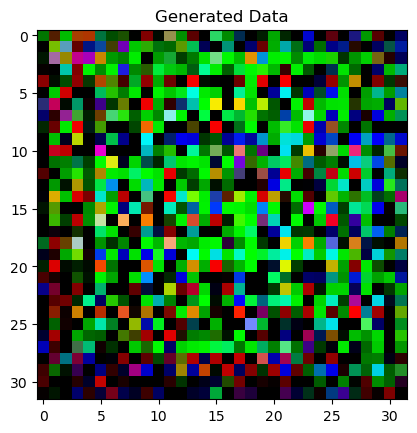

In [114]:
plt.imshow(faked[4].permute(1,2,0).detach().numpy())
plt.title("Generated Data")

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        #parameters
        
        #modules
        